In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-04-07 06:07:58.137512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 06:07:58.137622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 06:07:58.424438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = VGG16()
# Restructured model
model = Model(inputs=model.inputs,outputs = model.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Model Summary
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
BASE_DIR = "/kaggle/input/flickr8k"
WORKING_DIR = "/kaggle/working/"

In [5]:
features = {}
directory = os.path.join(BASE_DIR, "Images")
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Convert img into pixels
    image = img_to_array(image)
    #reshape
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess image
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # image ID
    image_id = img_name.split('.')[0]

    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1712470122.336946      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# Storing features in pickle file for further use
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# Loading features from pickle file
# with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
#   features = pickle.load(f)

In [7]:
# Captions data
with open(os.path.join(BASE_DIR, 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# captions_doc


In [8]:
# Creating mapping for catptions and correspomding image
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0] , tokens[1:]
    # removing extention from image
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
# captions after cleaning (ie is removing all the unnecesary words)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
# capt = mapping[key]

In [15]:
len(all_captions)

40455

In [16]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [17]:
vocab_size

8485

In [18]:
# maximum length of the captions
max_length = max(len(caption.split()) for caption in all_captions)

In [19]:
max_length # can be used for pad sequence

35

### Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Data generations to get data in batches
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

#### Model Creation

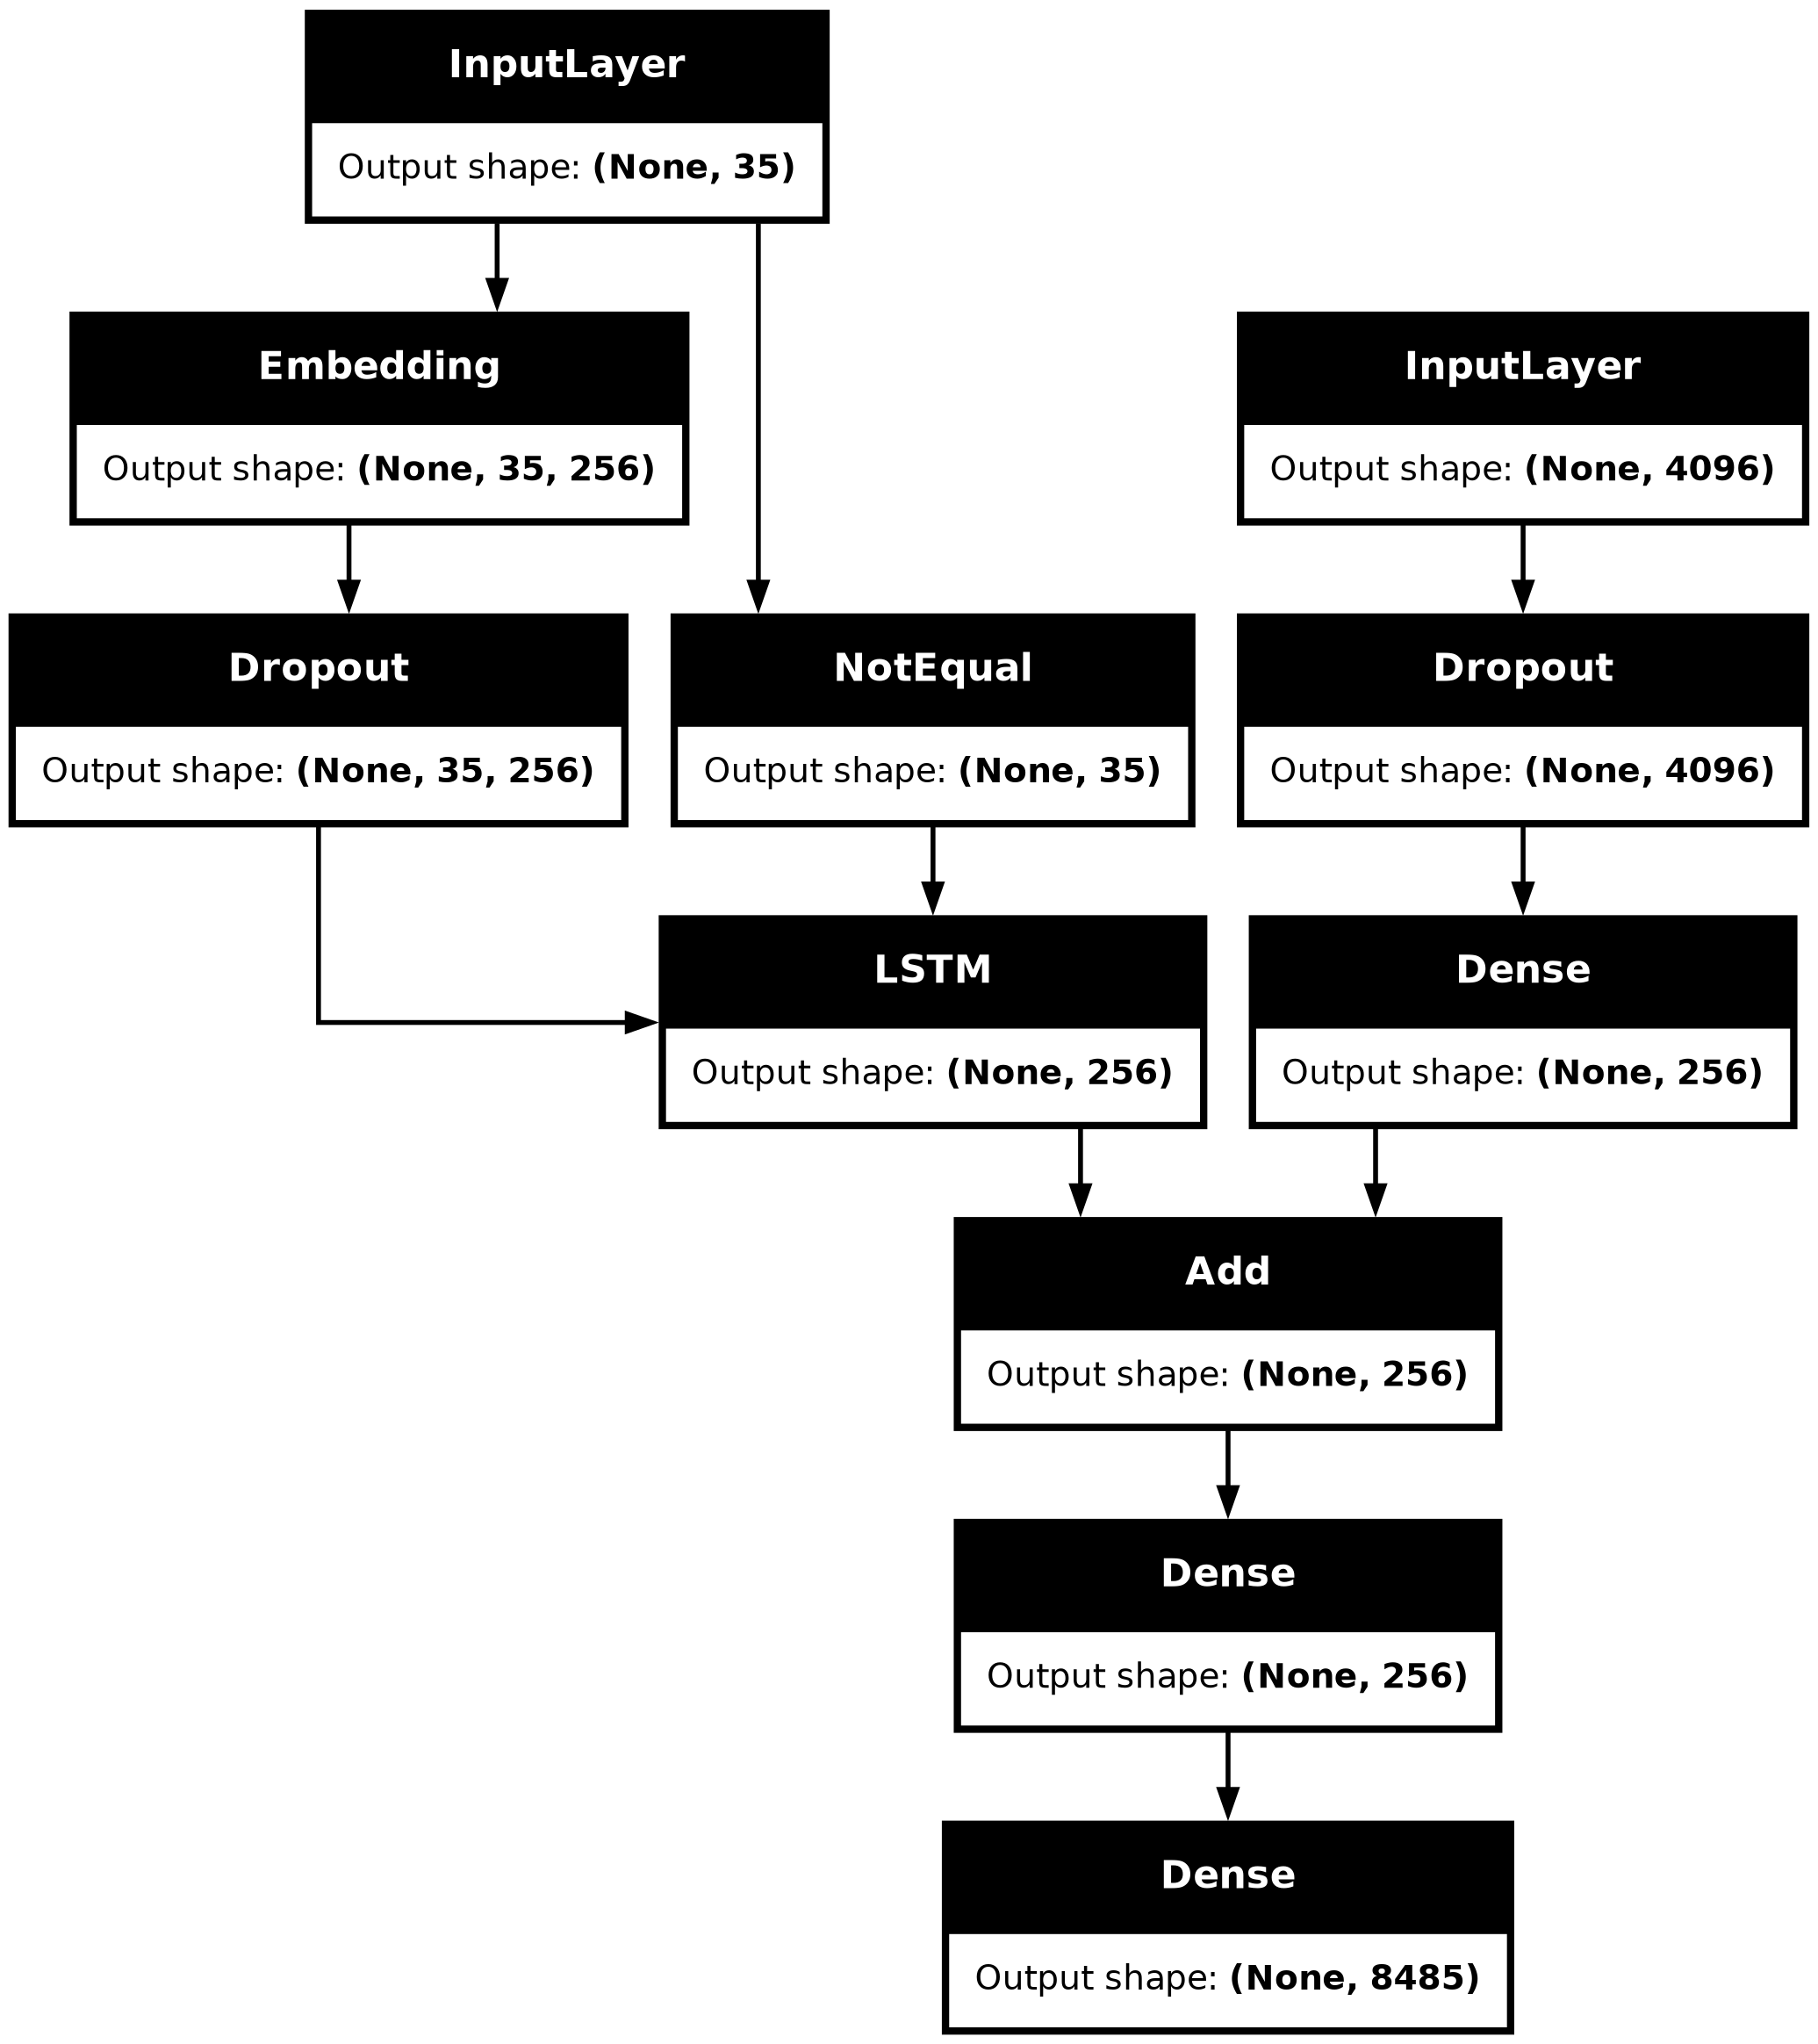

In [22]:
# image features model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model

plot_model(model, show_shapes=True)

In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 272ms/step - loss: 5.7504
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 4.0632
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 3.5893
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 3.3071
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 3.0964
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.9327
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.8160
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.7267
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.6493
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.5754
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.5148
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.4589
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.4095
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.3661
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 277ms/step - loss: 2.3264
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.2857
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.24

In [24]:
# saving the model
model.save(WORKING_DIR+ '/image_caption_model.h5')

### Generating the captions for the image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# Generating captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [27]:
# Validating the model
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.461538
BLEU-2: 0.196116


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.545455
BLEU-2: 0.330289
BLEU-1: 0.526316
BLEU-2: 0.324443
BLEU-1: 0.480769
BLEU-2: 0.264787
BLEU-1: 0.484375
BLEU-2: 0.271823
BLEU-1: 0.461538
BLEU-2: 0.253185
BLEU-1: 0.461538
BLEU-2: 0.267261
BLEU-1: 0.435185
BLEU-2: 0.255495
BLEU-1: 0.425000
BLEU-2: 0.239651
BLEU-1: 0.470149
BLEU-2: 0.275373
BLEU-1: 0.482517
BLEU-2: 0.283583
BLEU-1: 0.481250
BLEU-2: 0.273476
BLEU-1: 0.485549
BLEU-2: 0.264193
BLEU-1: 0.470588
BLEU-2: 0.250127
BLEU-1: 0.469072
BLEU-2: 0.250783
BLEU-1: 0.467980
BLEU-2: 0.245075
BLEU-1: 0.483412
BLEU-2: 0.259382
BLEU-1: 0.486607
BLEU-2: 0.274935
BLEU-1: 0.482906
BLEU-2: 0.268094
BLEU-1: 0.483871
BLEU-2: 0.272541
BLEU-1: 0.482759
BLEU-2: 0.269098
BLEU-1: 0.476364
BLEU-2: 0.263943
BLEU-1: 0.477352
BLEU-2: 0.272276
BLEU-1: 0.479592
BLEU-2: 0.269865
BLEU-1: 0.488525
BLEU-2: 0.286361
BLEU-1: 0.482866
BLEU-2: 0.286080
BLEU-1: 0.478788
BLEU-2: 0.281083
BLEU-1: 0.478261
BLEU-2: 0.285430
BLEU-1: 0.483051
BLEU-2: 0.288502
BLEU-1: 0.489130
BLEU-2: 0.292200
BLEU-1: 0.4883

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the beach endseq


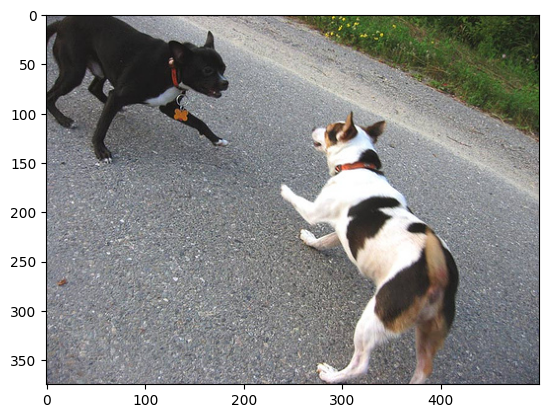

In [29]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man and woman sit on bench endseq


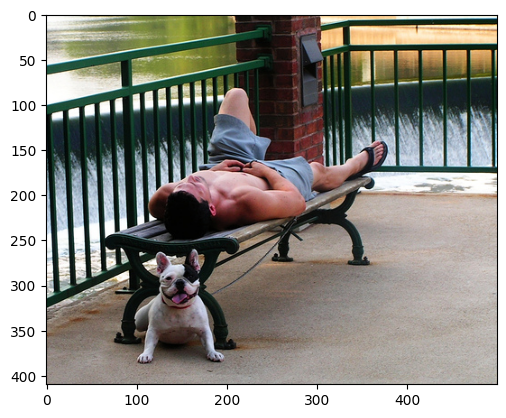

In [30]:
generate_caption("1003163366_44323f5815.jpg")

---------------------Actual---------------------
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
--------------------Predicted--------------------
startseq dog is running through water with stick in its mouth endseq


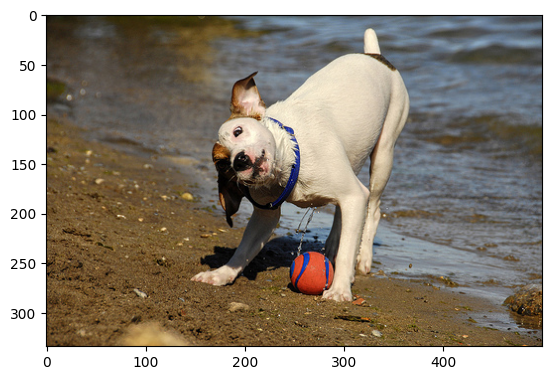

In [31]:
generate_caption("1012212859_01547e3f17.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two toddlers are playing in the rainbow endseq


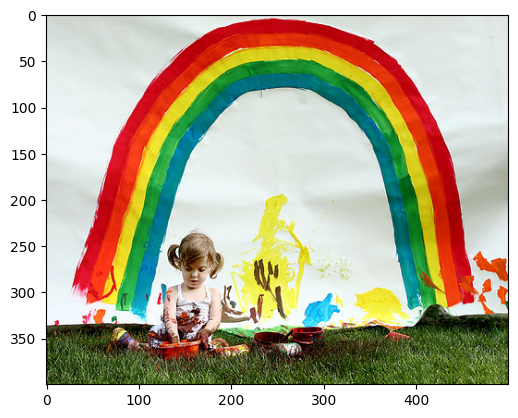

In [32]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man in green shirt is standing on the side of skyscraper endseq


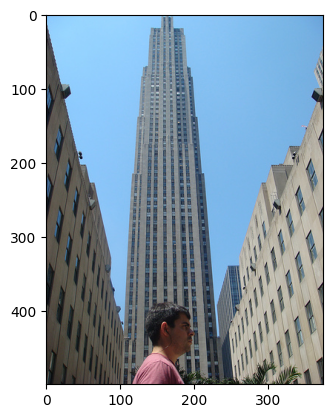

In [33]:
generate_caption("1032460886_4a598ed535.jpg")